# Вопрос ЧТО?: задача классификации

Есть дата сет в котором представлено несколько поездок на автомобилях с разными типами коробки передач (механика/вариатор)
Каждая поездка автомобиля это отдельный trackid.
По каждому trackid есть некое кол-во записей.
В каждой записи отображается:
    - rpm = кол-во оборотов
    - acceleration = ускорение
    - deacceleration = торможение
    - speed = скорость

Нужно определить какой trackid отноститься к поездке на вариаторе или механике

# Вопрос ЗАЧЕМ?:
Теоретически на данных подобного рода можно остлеживать стиль вождения автомобиля 
и определять "лихачей" любящих погонять.
Вполне актуальная задача для страховых компаний


# Вопрос КАК СДЕЛАНО?: 
На входе датасет по нескольким объектам.
По каждому объекту есть ряд наблюдений.

Разбил решение задачи на два ключевых этапа:

    - Этап 1: придумать логику, по которой на уровне наблюдей смогу сделать признак.
    Нужно чтобы чтобы данный признак давал ответ на главный вопрос и что бы его возможно было агрегировать 
    до уровня объекта, перейдя с уровня наблюдений.
    
    - Этап 2: использовать для кластеризации модель KMeans.
    
Этап 1 [Решение]: построчно посчитал изменение кол-ва оборотов и изменение скорости между текущей и предыдущей точкой наблюдения. Далее расчитал отношение изменение скорости к изменению кол-ва оборотов (рассчетная фича). Далее сложил все полученные значения рассчетной фичи отдельно по каждому объекту и получил таблицу в которой в строке уникальное значение объекта и проссумирование значение рассчетной фичи.

Этап 2 [Решение]: загрузил в модель KMeans.    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import time

In [2]:
start_time = time.time()
# загрузил файл
df = pd.read_excel('test_task.xlsx', encoding='utf-8')

In [3]:
# посмотрел статистику и проверил есть ли пропуски значений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36137 entries, 0 to 36136
Data columns (total 6 columns):
trackid                         36137 non-null int64
number of point in the track    36137 non-null int64
rpm                             36137 non-null int64
acceleration                    36137 non-null float64
deacceleration                  36137 non-null float64
speed                           36137 non-null int64
dtypes: float64(2), int64(4)
memory usage: 1.7 MB


In [4]:
# сделал копию датафрема оставив исходный, на случай если понадобяться исходные данные, то к нему можно было бы обратиться
df2 = df.copy(deep=True)

In [5]:
# установил в качестве индекса значения из колонки trackid
# задублированную колонку удалил
df2.index = df2['trackid']
df2 = df2.drop(['trackid'], axis=1)
df2.head()

,number of point in the track,rpm,acceleration,deacceleration,speed
trackid,,,,,
183166,1,0,0.046666,-0.018075,0
183166,2,0,0.028628,-0.015434,0
183166,3,0,0.027993,-0.018982,0
183166,4,0,0.048617,-0.025555,0
183166,5,0,0.000000,0.000000,0


In [6]:
# добавил пустые колонки для будуших расчетов
df2['rpm_dif'] = ""
df2['speed_dif'] = ""
df2['speed_dif / rpm_dif'] = ""

In [7]:
# df4['rpm_dif'] - Колонка в которой расчитал изменение rpm по сравнению с предыдущей точкой
df4 = df2
df4 = df4.reset_index()
df4all = df4['rpm'].iloc[:-1]
df4all[-1] = 0
df4all.index = df4all.index + 1
df4all = df4all.sort_index()
df4['rpm_dif'] = df4['rpm'] - df4all

In [8]:
# df4['speed_dif'] - Колонка в которой расчитал изменение speed по сравнению с предыдущей точкой
df4 = df4
df4 = df4.reset_index(drop=True)
df4all = df4['speed'].iloc[:-1]
df4all[-1] = 0
df4all.index = df4all.index + 1
df4all = df4all.sort_index()
df4['speed_dif'] = df4['speed'] - df4all

In [9]:
# для классификации поездок решил сгенерировать новый признак (отношение изменение сокрости к изменению оборотов)
# поскольку на вариаторе нет переключения скоростей и общая сумма по новому признаку должна быть по идее ниже.
# в данных есть ситуации когда 0 делим на число или наоборот число на 0.
# в результате при расчете новой фичи возникли inf / -inf. 
# данное значение (inf) при агрегации данных не давало возможности загрузить данные в модель. 
# для этого применил "хитрость" введя в места пропуска маленькие значения в числитель и знаменатель.  
# (посчитал подобные изменения допустимыми)


# отобрал в фильтр те строки в которых изменение скорости равно 0 (исключил ситуцию деления на ноль)
filt = df4['speed_dif'] == 0
df4[filt]
df4.loc[df4[filt].index.values,'speed_dif'] = 0.001
df4.loc[df4[filt].index.values,'rpm_dif'] = 0.001


# отобрал в фильтр те строки в которых изменение rpm равно 0 и делиться на какое-то число (исключил ситуации в которых
# получалось значение inf / -inf)
filt = (df4['rpm_dif'] == 0) & (df4['speed_dif'] != 0)
df4[filt]
df4.loc[df4[filt].index.values,'speed_dif'] = 0.001
df4.loc[df4[filt].index.values,'rpm_dif'] = 0.001


In [10]:
# расчет нового признака (отношение изменение сокрости к изменению оборотов)
df4['speed_dif / rpm_dif'] = df4['speed_dif'] / df4['rpm_dif']

In [11]:
# добавил колонку маркер чтобы использовать для след шага
df4['Marker'] = 1

In [12]:
# посколку в новом признаке перемножались два столбца в которых было возможно 4 комбинации знаков:
# '++', '+-', '-+', '--' то по правилам умножения у четвертой комбинации '--' получался знак плюс. 
# хотя для накопительного эффекта подсчета суммы по новому признаку требовалось сохранить знак минус. 
# для этого ввел доп колонку в которой для подобных случаев проставил значение -1 и в последствии на 
# него умножил приведя значения знаков нового параметра в нужное состояние"""
filt = (df4['rpm_dif']<0)&(df4['speed_dif']<0)
df4[filt]
df4.loc[df4[filt].index.values,'Marker'] = -1
df4['speed_dif / rpm_dif'] = df4['speed_dif / rpm_dif'] * df4['Marker']
df4['speed_dif / rpm_dif'] = df4['speed_dif / rpm_dif'].astype(float)

In [13]:
# подготовительные расчеты доп фичи произведены
# теперь нужно несколько строк наблюедний по одному объекту 'trackid' и колонке 'speed_dif / rpm_dif' просуммировать
# и получить всего 1 строку по 1 trackid, чтобы далее можно было построить модель KMeans
df5 = df4.groupby('trackid').agg({'speed_dif / rpm_dif': 'sum'})

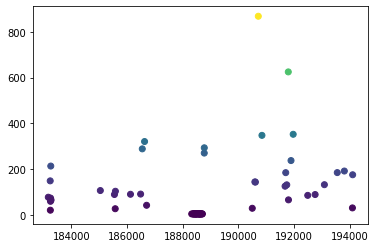

In [14]:
# построил график на котором посмотрел распределение точек
x_axis = df5.index
y_axis = df5['speed_dif / rpm_dif']
plt.scatter(x_axis, y_axis, c=df5['speed_dif / rpm_dif'])
plt.show()

In [15]:
# запустил модель KMeans
model = KMeans(n_clusters=2, n_init=2)
model.fit(df5)
all_predictions = model.predict(df5)
allp = pd.DataFrame(all_predictions, columns=['CLASS'])
allp = allp.assign(trackid = df5.index)
allp.index = allp['trackid']
allp = allp.drop(['trackid'], axis = 1)
df5 = pd.merge(df5, allp, left_index=True, right_index=True)
df5.head(10)

,speed_dif / rpm_dif,CLASS
trackid,,
183166,77.858085,1
183235,149.259385,1
183240,21.232075,1
183245,59.987009,1
183248,73.997640,1
183255,213.847321,1
183266,65.483706,1
185037,106.997373,1
185544,89.667167,1


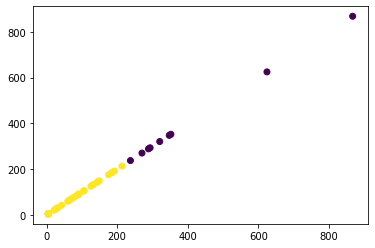

In [16]:
# посмотрел как распределились результаты полученые на основании модели
x_axis = df5['speed_dif / rpm_dif']
y_axis = df5['speed_dif / rpm_dif'] 
plt.scatter(x_axis, y_axis, c=df5['CLASS'])
plt.show()

In [17]:
# для читаемости нужно подписать значения классов.
# но при перезапуске ноутбука значение 0 и 1 меняется местами для одного и того же класса
# для решения данной проблемы сравниваю максимум из кажодого класса
# и тому мах что больше условием присваиваю значение 'Механика'
filt_0 = (df5['CLASS'] == 0)
max_0 = df5[filt_0]
max_0 = max_0['speed_dif / rpm_dif'].max()

filt_1 = (df5['CLASS'] == 1)
max_1 = df5[filt_1]
max_1 = max_1['speed_dif / rpm_dif'].max()

df5['CLASS2'] = ''

if max_0 > max_1:
    df5['CLASS2'][df5['CLASS'] == 0] = 'Механика'
    df5['CLASS2'][df5['CLASS'] == 1] = 'Вариатор'
elif max_0 < max_1:
    df5['CLASS2'][df5['CLASS'] == 0] = 'Вариатор'
    df5['CLASS2'][df5['CLASS'] == 1] = 'Механика'

C:\Users\HaritonovDV\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\HaritonovDV\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
# вывод сводной таблицы чтобы посмотреть что получилось
pivot = pd.pivot_table(df5, index=['CLASS2','trackid'])
pivot

CLASS  speed_dif / rpm_dif
CLASS2   trackid                            
Вариатор 183166       1            77.858085
         183235       1           149.259385
         183240       1            21.232075
         183245       1            59.987009
         183248       1            73.997640
...                 ...                  ...
Механика 190716       0           867.653361
         190847       0           347.802467
         191794       0           624.766254
         191892       0           237.833046
         191970       0           352.493331

[61 rows x 2 columns]

In [19]:
# выгрузка в excel результатов
# df5.to_excel('Transmission_answer.xlsx')

In [20]:
finish_time = time.time()
work_time = finish_time - start_time
print(work_time)

6.801680326461792
